In [1]:
from jax import config

config.update("jax_enable_x64", True)

In [2]:
import optax
from jax import jit
from jax import numpy as jnp
from jax import random
from jax import lax
from jax import scipy
from jax import value_and_grad
from jax import vmap
from matplotlib import pyplot as plt

In [3]:
from bojax.prediction import bijectors, kernels, means
from bojax.prediction.processes import gaussian
from bojax._src.util import compose

In [4]:
SEED = 42
BOUND = 3
NUM_DATA = 100
NOISE = 0.3
LEARNING_RATE = 0.01

In [5]:
data_key, sample_key = random.split(random.PRNGKey(SEED))

In [6]:
def sinusoidal(x):
    return jnp.sin(4 * x[..., 0]) + jnp.cos(2 * x[..., 0])

In [7]:
xs = jnp.linspace(-BOUND-0.5, BOUND + 0.5, BOUND * 100 + 1)[..., jnp.newaxis]
ys = sinusoidal(xs)

In [8]:
x_train = random.uniform(data_key, minval=-BOUND, maxval=BOUND, shape=(NUM_DATA, 1))
y_train = sinusoidal(x_train) + random.normal(random.fold_in(data_key, 1), shape=(NUM_DATA,)) * NOISE

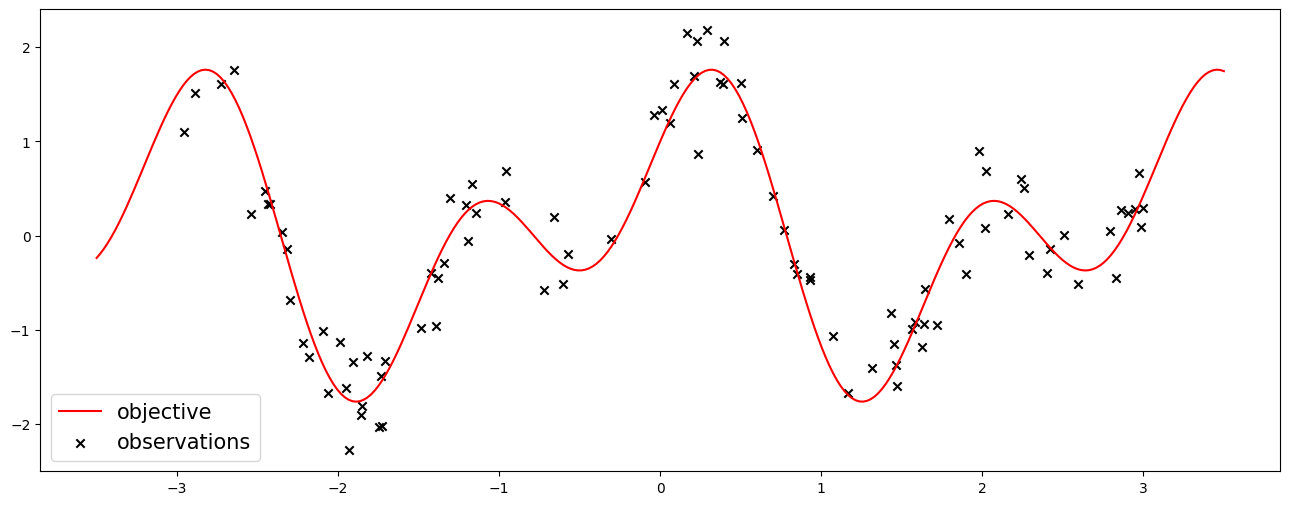

In [9]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(xs, ys, c='red', label='objective')
ax.scatter(x_train, y_train, marker='x', c='black', label='observations')

plt.legend(fontsize=15)
plt.show()

In [10]:
bijector = bijectors.softplus()
optimizer = optax.adam(LEARNING_RATE)

In [11]:
def prior(params):
    return gaussian.prior(
        vmap(means.zero()),
        vmap(vmap(kernels.scale(bijector.forward(params['amplitude']), kernels.rbf(bijector.forward(params['length_scale']))), in_axes=(None, 0)), in_axes=(0, None)),
        bijector.forward(params['noise']),
    )

In [12]:
def posterior(params, x_train, y_train):
    return gaussian.posterior(
        x_train,
        y_train,
        vmap(means.zero()),
        vmap(vmap(kernels.scale(bijector.forward(params['amplitude']), kernels.rbf(bijector.forward(params['length_scale']))), in_axes=(None, 0)), in_axes=(0, None)),
        bijector.forward(params['noise']),
    )

In [13]:
params = {
    'amplitude': bijector.inverse(jnp.ones(())),
    'length_scale': bijector.inverse(jnp.ones(())),
    'noise': bijector.inverse(jnp.array(1e-3)),
}

In [14]:
prior_loc, prior_cov = prior(params)(xs)

In [15]:
prior_scale = jnp.sqrt(jnp.diag(prior_cov))

In [16]:
prior_samples = random.multivariate_normal(random.fold_in(sample_key, 0), prior_loc, prior_cov, shape=(20,))

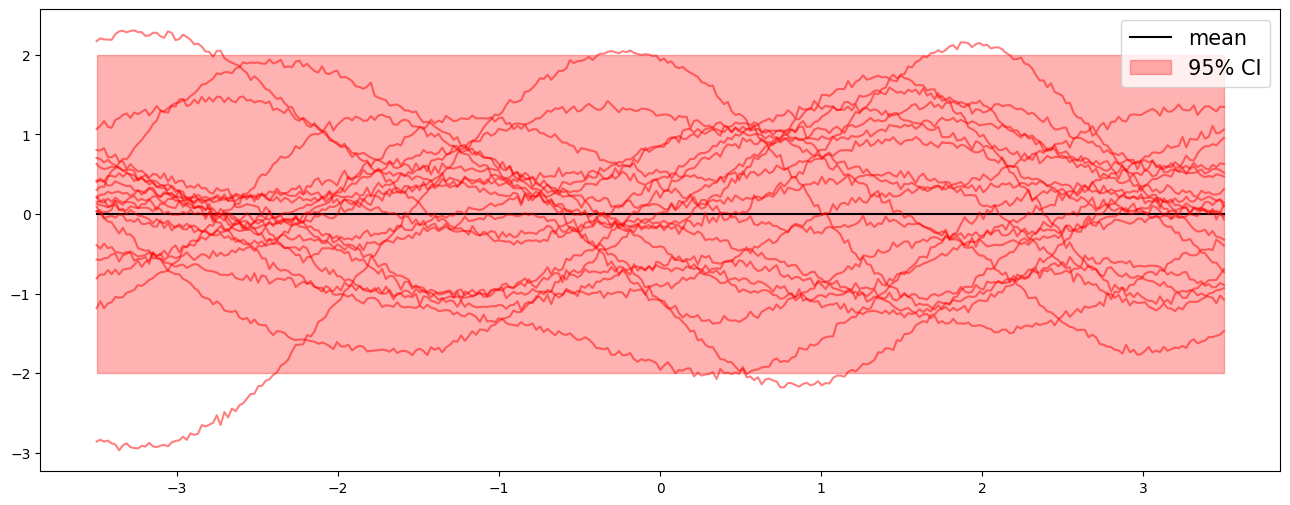

In [17]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(xs, prior_loc, color='black', label='mean')
ax.plot(xs, prior_samples.T, alpha=0.5, color='red')
ax.fill_between(xs[..., 0], prior_loc - 2 * prior_scale, prior_loc + 2 * prior_scale, alpha=0.3, color='red', label='95% CI')

ax.legend(loc='best', fontsize=15)

plt.show()

In [18]:
def fit(params, opt_state, x_train, y_train, num_iterations):
    def train_step(state, iteration):
        def loss_fn(params):            
            loc, scale = prior(params)(x_train)
            return -scipy.stats.multivariate_normal.logpdf(y_train, loc, scale)

        loss, grads = value_and_grad(loss_fn)(state[0])
        updates, opt_state = optimizer.update(grads, state[1])
        params = optax.apply_updates(state[0], updates)

        return (params, opt_state), loss

    return lax.scan(
        jit(train_step),
        (params, opt_state),
        jnp.arange(num_iterations)
    )

In [19]:
(next_params, next_opt_state), history = fit(params, optimizer.init(params), x_train, y_train, 500)

In [20]:
next_params

{'amplitude': Array(1.43479667, dtype=float64),
 'length_scale': Array(-0.40062909, dtype=float64),
 'noise': Array(-4.52416483, dtype=float64)}

In [21]:
{k: bijector.forward(v) for k, v in next_params.items()}

{'amplitude': Array(1.64842613, dtype=float64),
 'length_scale': Array(0.51276284, dtype=float64),
 'noise': Array(0.01078539, dtype=float64)}

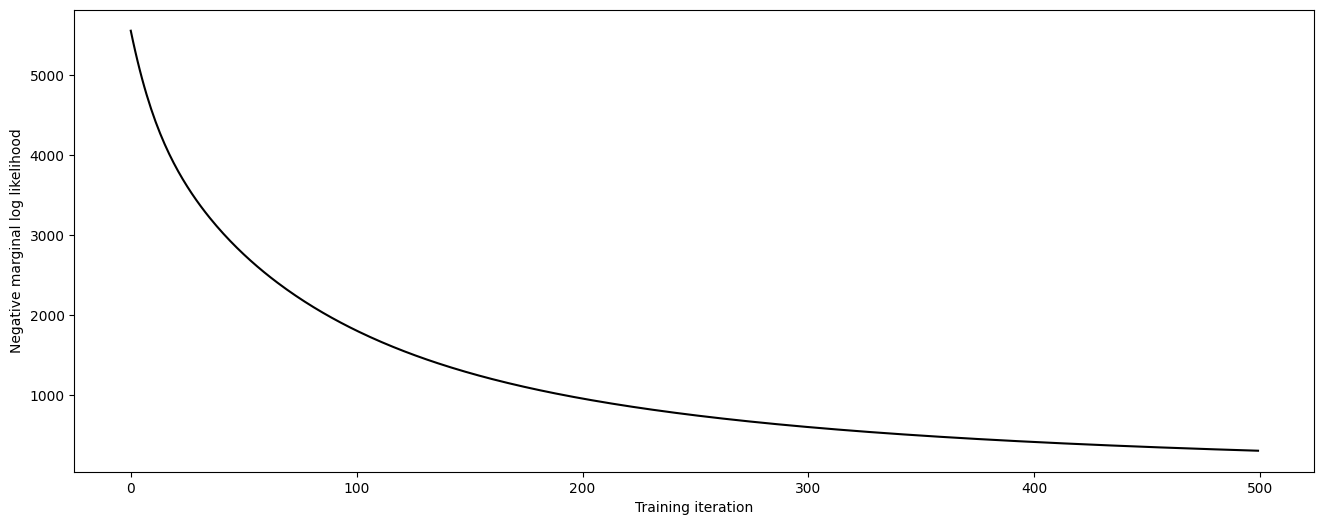

In [22]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(history, color='black')
ax.set(xlabel='Training iteration', ylabel='Negative marginal log likelihood')

plt.show()

In [23]:
posterior_loc, posterior_cov = posterior(next_params, x_train, y_train)(xs)

In [24]:
posterior_scale = jnp.sqrt(jnp.diag(posterior_cov))

In [25]:
posterior_samples = random.multivariate_normal(random.fold_in(sample_key, 1), posterior_loc, posterior_cov, shape=(20,))

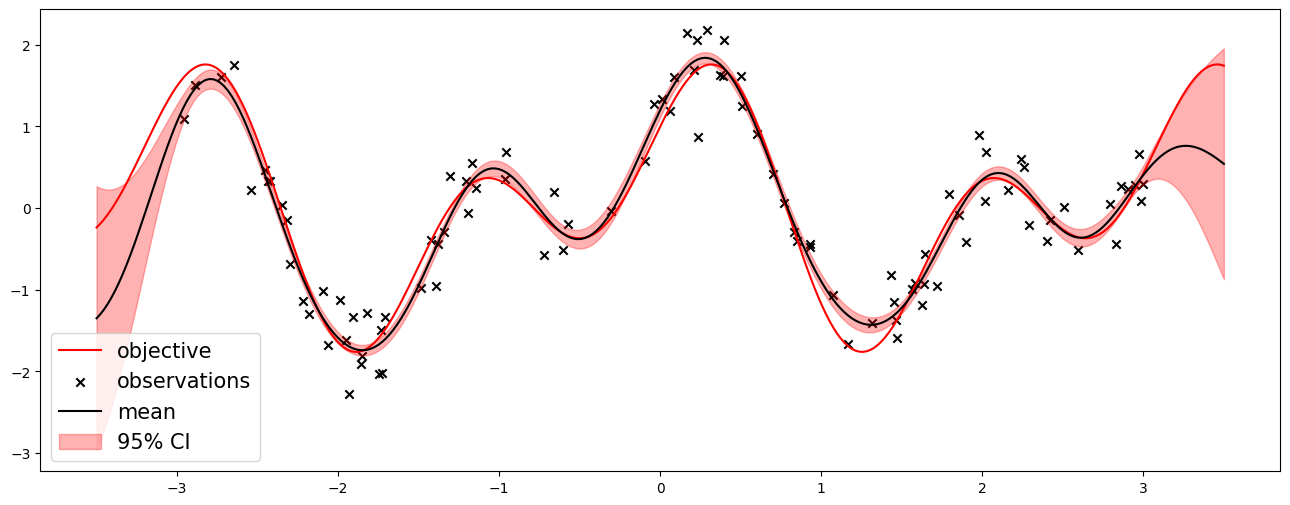

In [26]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(xs, ys, c='red', label='objective')
ax.scatter(x_train, y_train, marker='x', c='black', label='observations')
ax.plot(xs, posterior_loc, color='black', label='mean')
# ax.plot(xs, posterior_samples.T, alpha=0.5, color='red')
ax.fill_between(xs[..., 0], posterior_loc - 2 * posterior_scale, posterior_loc + 2 * posterior_scale, alpha=0.3, color='red', label='95% CI')

ax.legend(loc='best', fontsize=15)

plt.show()